In [1]:
from diffusers import UNet2DModel
from diffusers import DDIMScheduler
from diffusers import SchedulerMixin
import PIL.Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from safetensors.torch import save_file, safe_open
import gc
from aux_functions import *

c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\tesi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
DDIM_pipeline_path = "outputs/output_DDIM_128"  
DDIM_model_path = DDIM_pipeline_path+"/unet"
DDIM_scheduler_path = DDIM_pipeline_path + "/scheduler"
DDPM_pipeline_path = "outputs/output_DDPM_128"  
DDPM_model_path = DDPM_pipeline_path+"/unet"
DDPM_scheduler_path = DDPM_pipeline_path + "/scheduler"
DDIM_inversion_path = "outputs/inversion_DDIM_128_inference"
DDPM_inversion_path = "outputs/inversion_DDPM_128"
if not os.path.exists(DDIM_inversion_path):
    os.makedirs(DDIM_inversion_path)
if not os.path.exists(DDPM_inversion_path):
    os.makedirs(DDPM_inversion_path)

In [3]:
import PIL.Image
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)

def generatorD(initial_img: torch.Tensor|None, M: UNet2DModel, S: SchedulerMixin, paths: str, num_timesteps: int, seed: int = 0):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = paths

    model = M.from_pretrained(model_path)
    model = model.to(device)

    model.eval()

    scheduler = S()

    scheduler.set_timesteps(num_timesteps)

    if initial_img == None:
        initial_img = torch.randn(1, 1, 128, 128).to(device)

    image_generated = initial_img.clone().to(device)

    generator = torch.Generator(device='cpu').manual_seed(seed)

    for t in range(num_timesteps):
        predicted_noise = model.forward(image_generated, t).sample
        image_generated = scheduler.step(predicted_noise, t, image_generated, generator=generator).prev_sample

    return image_generated

def inversion(target: torch.Tensor, S: SchedulerMixin, paths: str, num_timesteps: int, seed: int, save_path: str, initial_noise, start_from = 0):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = paths

    M = UNet2DModel

    class custom_loss(torch.nn.Module):
        def __init__(self):
            super(custom_loss, self).__init__()

        def forward(self, x_pred, x_true):
            lam =1e-3
            z = torch.randn_like(target)
            return torch.sum(torch.square(x_pred - x_true)) + (lam * torch.sum(torch.square(z)))

    loss_fun = custom_loss()

    if initial_noise is None:
        z = torch.randn(target.size()).to(device).requires_grad_(True)
        print("Initial noise Generated")
    elif start_from > 0:
        z = safe_open(DDIM_inversion_path+"/noise_490.safetensors","pt",device=0).get_tensor("z").requires_grad_(True).to(device)
        print("Initial noise Loaded")

    optimizer = torch.optim.AdamW([z], lr=1e-2)

    scaler = GradScaler()
    
    print(type(z), z.shape, z.dtype)

    save_image(z, save_path+"/init_noise.png")
    save_image(target, save_path+"/target.png")

    for i in range(num_timesteps):

        #with autocast():
        x = generatorD(z, M, S, paths, 25, seed)
        #print("Gradiente Salvato?",x.requires_grad)
        loss = loss_fun(x, target)
        
        #print("require grad",z.requires_grad)

        #provare senza scaler
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        loss.backward()
        optimizer.step()

        print(f"Step {i+start_from} - Loss: {loss.item()}")
        torch.cuda.empty_cache()
        #save tensor
        if i % 10 == 0 and i > 0:
            st = {
                "z": z,
                "grad": z.grad,
            }
            save_file(st, save_path+f"/noise_{i+start_from}.safetensors")
            print(f"Saved noise_{i+start_from}.safetensors")
            if ((i+start_from-10) % 100) != 0:
                if os.path.exists(save_path+f"/noise_{i+start_from-10}.safetensors"):
                    os.remove(save_path+f"/noise_{i+start_from-10}.safetensors")
                    print(f"Removed noise_{i+start_from-10}.safetensors")

        optimizer.zero_grad()

    save_file(st, save_path+f"/noise_{num_timesteps+start_from}.safetensors")
    print(f"Saved noise_{num_timesteps+start_from}.safetensors")

    torch.cuda.empty_cache()
    gc.collect()

    save_image(z, save_path+"/opt_noise.png")


In [4]:
#print(torch.cuda.memory_summary())
torch.cuda.empty_cache()
gc.collect()

#path = "../../datasets/Mayos/test/C081/0.png"
path = "outputs/generated_DDIM_128/2.png"
pil_image = PIL.Image.open(path).convert("L")
#convert image to numpy
np_image = np.array(preprocess(pil_image),dtype=np.float32)
tensor_image = torch.tensor(np_image,requires_grad=True)
tensor_image = tensor_image.unsqueeze(0)
tensor_image = tensor_image.to("cuda")

sched = 'DDIM'
if sched == 'DDIM':
    inversion(tensor_image, DDIMScheduler, DDIM_model_path, 200, 42, DDIM_inversion_path,None)
else:
    inversion(tensor_image, DDIMScheduler, DDPM_model_path, 200, 42, DDPM_inversion_path,None)

Initial noise Generated
<class 'torch.Tensor'> torch.Size([1, 1, 128, 128]) torch.float32


c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\tesi\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


Step 0 - Loss: 4281.6279296875
Step 1 - Loss: 4142.37646484375
Step 2 - Loss: 3972.194091796875
Step 3 - Loss: 3749.450927734375
Step 4 - Loss: 3674.731201171875
Step 5 - Loss: 3650.3486328125
Step 6 - Loss: 3644.371826171875
Step 7 - Loss: 3609.3330078125
Step 8 - Loss: 3573.527587890625
Step 9 - Loss: 3527.059326171875
Step 10 - Loss: 3491.983154296875
Saved noise_10.safetensors
Step 11 - Loss: 3457.985595703125
Step 12 - Loss: 3417.8955078125
Step 13 - Loss: 3363.7646484375
Step 14 - Loss: 3314.861083984375
Step 15 - Loss: 3280.10595703125
Step 16 - Loss: 3237.1220703125
Step 17 - Loss: 3196.34033203125
Step 18 - Loss: 3159.840087890625
Step 19 - Loss: 3122.444580078125
Step 20 - Loss: 3072.9140625
Saved noise_20.safetensors
Removed noise_10.safetensors
Step 21 - Loss: 3017.661376953125
Step 22 - Loss: 2973.886962890625
Step 23 - Loss: 2948.161865234375
Step 24 - Loss: 2902.514404296875
Step 25 - Loss: 2864.35400390625
Step 26 - Loss: 2830.17724609375
Step 27 - Loss: 2790.7419433593

In [4]:
#path = "../../datasets/Mayos/test/C081/0.png"
path = "outputs/generated_DDIM_128/2.png"
gc.collect()
torch.cuda.empty_cache()


#path = "outputs/generated_DDIM_128/2.png"
pil_image = PIL.Image.open(path).convert("L")
#convert image to numpy
np_image = np.array(preprocess(pil_image),dtype=np.float32)
tensor_image = torch.tensor(np_image,requires_grad=True)
tensor_image = tensor_image.unsqueeze(0)
tensor_image = tensor_image.to("cuda")

def compare_images(noise_step: int):
    saved_tensors = safe_open(DDIM_inversion_path+f"/noise_{noise_step}.safetensors","pt",device='cpu')
    #print(saved_tensors.keys())
    saved_tensor = saved_tensors.get_tensor("z").to("cuda").requires_grad_(True)
    #image_generated = inversion(tensor_image, DDIMScheduler, DDIM_model_path, 11, 42, DDIM_inversion_path,saved_tensor,491)
    reconstructed = generatorD(saved_tensor, UNet2DModel, DDIMScheduler, DDIM_model_path, 25, 42)[0]

    gc.collect()
    torch.cuda.empty_cache()

    figure = plt.figure(figsize=(10, 10))
    cols = 3
    rows = 1
    figure.add_subplot(rows, cols, 1)
    plt.imshow(tensor_to_numpy(saved_tensor), cmap="gray")
    plt.title(f"Rumore Ottimizzato")
    plt.axis("off")
    figure.add_subplot(rows, cols, 2)
    plt.imshow(tensor_to_numpy(reconstructed), cmap="gray")
    plt.title(f"Immagine Ricostruita")
    plt.axis("off")
    figure.add_subplot(rows, cols, 3)
    plt.imshow(tensor_to_numpy(tensor_image), cmap="gray")
    plt.title(f"Immagine Originale")
    plt.axis("off")
    plt.show()

    show_metrics(reconstructed, tensor_image)

def show_metrics(reconstructed, target):
    #measure metrics on the reconstructed image
    MSE = torch.nn.functional.mse_loss(reconstructed, target)
    print("MSE:", MSE.item())

    print("PSNR: ", 10 * torch.log10(tensor_image.max()**2 / MSE).item())


c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\tesi\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


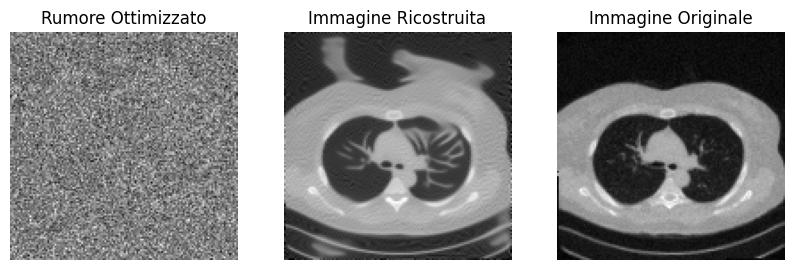

C:\Users\panal\AppData\Local\Temp\ipykernel_2412\950807707.py:46: UserWarning: Using a target size (torch.Size([1, 1, 128, 128])) that is different to the input size (torch.Size([1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = torch.nn.functional.mse_loss(reconstructed, target)


MSE: 0.0544605627655983
PSNR:  5.414835810661316
Step 100
---------------------------------------------------


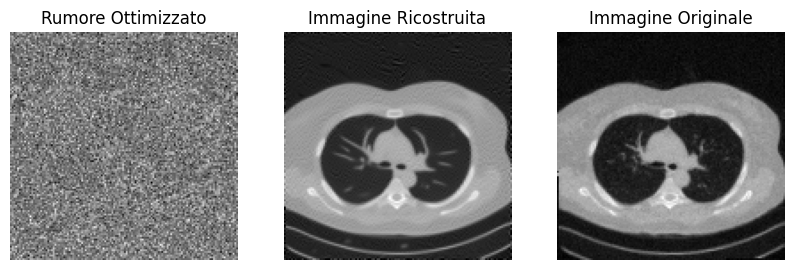

MSE: 0.01106006558984518
PSNR:  12.338080406188965
Step 200
---------------------------------------------------


In [5]:
compare_list = [100,200]

for i in compare_list:
    compare_images(i)
    print(f"Step {i}")
    print("---------------------------------------------------")

In [6]:
#measure metrics on the reconstructed image
#MSE = torch.nn.functional.mse_loss(reconstructed, tensor_image)
#print("MSE:", MSE.item())
#
#print("PSNR: ", 10 * torch.log10(tensor_image.max()**2 / MSE).item())
